# Метрики качества Генерации (Изображение)

### Цели
В этом ноутбуке, возникающих при оценке GAN, а также о способе их решения, который называется Fréchet Inception Distance (FID).

### Задачи обучения
1.   Понять проблемы, связанные с оценкой качества GAN.
2.   Написать код для оценки IS.
2.   Написать код для оценки расстояния Фреше.
3.    


Ссылки:

1. [A Note on the Inception Score](https://arxiv.org/pdf/1801.01973.pdf)
2. [A Study on the Evaluation of Generative Models](https://arxiv.org/pdf/2206.10935.pdf)
3. [Pros and Cons of GAN Evaluation Measures](https://arxiv.org/pdf/2103.09396.pdf)
4. [Improved Tech for Training GAN](https://arxiv.org/pdf/1606.03498.pdf)
5. [Analyzing and Improving the Image Quality of StyleGAN](https://arxiv.org/pdf/1912.04958.pdf)

## Проблемы, связанные с оценкой GAN-систем

#### Функции потерь неинформативны
Одним из аспектов, затрудняющих оценку GAN, является то, что функция потерь мало что говорят нам об их эффективности. В отличие от классификаторов, где низкий уровень потерь на тестовом наборе свидетельствует о высокой эффективности, низкий уровень потерь для генератора или дискриминатора говорит о том, что обучение прекратилось.


#### Нет четкой нечеловеческой метрики.
Если определить цель GAN как "генерирование изображений, которые кажутся людям реальными", то технически это можно измерить напрямую: [можно попросить людей выступить в роли дискриминатора](https://arxiv.org/abs/1904.01121). Однако это требует значительных затрат времени и средств, поэтому в идеале для этого можно использовать прокси. Также не существует "идеального" дискриминатора, который мог бы отличить подлинники от подделок - если бы он существовал, то многие задачи машинного обучения были бы решены ;)

В этом блокноте вы реализуете метод Fréchet Inception Distance, который призван решить эти проблемы.

## Оценка качества GAN моделей
Как оценивать качество генеративных моделей?
**Likelihood** модели
* Разбить данные на train/val/test
* Обучить модели на train
* Потюнить гиперпараметры на валидации
* Оценить обобщение модели на тестовом множестве

Не **Likelihood** модели
* VAE: compare ELBO values
* GAN: ????

## Начало работы
В этом блокноте мы будем использовать [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Начнем с загрузки предварительно обученного генератора, который был обучен на CelebA.

Здесь вы импортируете некоторые полезные библиотеки и пакеты

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Загрузка предварительно обученной модели

Теперь можно задать аргументы для модели и загрузить набор данных:
  * z_dim: размерность вектора шума
  * image_size: размер изображения на входе в Inception
  * device: тип устройства

In [15]:
# !gdown --id 1O8LE-FpN79Diu6aCvppH5HwlcR5I--PX
# !mkdir data
!unzip -qq img_align_celeba.zip -d data

In [1]:
from torchvision.datasets import ImageFolder
z_dim = 64
image_size = 299
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root="./data", transform=transform)

/home/mteterin/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mteterin/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


NameError: name 'transforms' is not defined

Затем можно загрузить и инициализировать модель с весами из предварительно обученной модели. Это позволяет использовать предварительно обученную модель так же, как если бы вы обучали ее самостоятельно.

In [2]:
gen = Generator(z_dim).to("cpu")
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device("cpu"))["gen"])
gen = gen.eval()

NameError: name 'Generator' is not defined

## Сеть Inception-v3
Inception-V3 - это нейронная сеть, обученная на [ImageNet](http://www.image-net.org/) для классификации объектов. ImageNet содержит более 1 млн. изображений для обучения. В результате Inception-V3 хорошо справляется с обнаружением признаков и классификацией изображений. Здесь вы загрузите Inception-V3 под именем `inception_model`.

<!--  
В прошлом люди использовали предварительно обученную сеть Inception для определения классов объектов, сгенерированных GAN, и измеряли, насколько распределение сгенерированных классов похоже на истинное изображение (с помощью KL-расхождения). Этот показатель известен как inception score.

Однако с этой метрикой связано много проблем. В работе Барратта и Шармы 2018 года "[A Note on the Inception Score](https://arxiv.org/pdf/1801.01973.pdf)" освещается множество проблем, связанных с этим подходом. Среди них они выделяют его нестабильность, возможность эксплуатации и широкое использование Inception Score на моделях, не обученных на ImageNet.  -->



In [3]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=True)
inception_model.to("cpu")
inception_model = inception_model.eval() # Evaluation mode

/home/mteterin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mteterin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Inception Score

Inception Score (оценка начала) является метрикой для оценки качества генеративных моделей, особенно в задачах генерации изображений. Она была предложена в 2016 году в статье "Improved Techniques for Training GANs" и основана на использовании предварительно обученной модели классификации изображений Inception.

Inception Score оценивает два аспекта сгенерированных изображений: качество (чем лучше изображение, тем выше оценка) и разнообразие (чем больше различных классов представлено на изображениях, тем выше оценка). Для вычисления Inception Score сначала генерируется набор изображений с помощью генеративной модели. Затем эти изображения подаются на вход предварительно обученной модели Inception для получения вероятностей принадлежности каждого изображения к различным классам. Наконец, вычисляется средняя Кульбака-Лейблера дивергенция между распределением классов для всех изображений и средним распределением классов.

Inception Score является одним из способов оценки качества генеративных моделей, но не является исчерпывающей метрикой и может не учитывать другие важные аспекты, такие как структура изображений или сохранение деталей. Он широко используется для сравнения разных моделей генерации изображений и может быть полезным инструментом при выборе наилучшей модели.

In [31]:
# calculate inception score in numpy
from numpy import asarray, expand_dims, log, mean, exp

# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = exp(avg_kl_d)
    return is_score

# conditional probabilities for high quality images
p_yx = asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
score = calculate_inception_score(p_yx)
print(score)

# conditional probabilities for low quality images
p_yx = asarray([[0.33, 0.33, 0.33], [0.33, 0.33, 0.33], [0.33, 0.33, 0.33]])
score = calculate_inception_score(p_yx)
print(score)


2.9999999999999996
1.0


## Fréchet Inception Distance

Fréchet Inception Distance (FID) был предложен как усовершенствование Inception Score и по-прежнему использует сеть Inception-v3 в своих расчетах. Однако вместо классификационных меток сети Inception-v3 она использует выходной сигнал более раннего слоя - слоя, расположенного непосредственно перед метками. Этот слой часто называют слоем признаков. Исследования показали, что глубокие конволюционные нейронные сети, обученные сложным задачам, таким как классификация множества классов, строят все более сложные представления признаков по мере углубления в сеть. Например, первые несколько слоев могут научиться определять различные виды краев и кривых, а в более поздних слоях могут быть нейроны, срабатывающие в ответ на человеческие лица.

Чтобы получить слой признаков в конволюционной нейронной сети, можно заменить последний полностью связанный слой слоем идентификации, который просто возвращает все полученные входные данные без изменений. Таким образом, по сути, удаляется последний классификационный слой и остаются промежуточные выходы предыдущего слоя.

In [4]:
inception_model.fc = torch.nn.Identity()

NameError: name 'torch' is not defined

### Расстояние Фреше
Расстояние Фреше использует значения из слоя признаков для двух наборов изображений, скажем, подлинников и подделок, и сравнивает различные статистические свойства между ними, чтобы определить, насколько они отличаются друг от друга. В частности, расстояние Фреше позволяет найти кратчайшее расстояние, необходимое для одновременного прохождения двух линий или двух кривых. Наиболее интуитивное объяснение расстояния Фреше - это "минимальное расстояние на поводке" между двумя точками. Представьте себе себя и свою собаку, движущихся по двум кривым. Если вы идете по одной кривой, а ваша собака, привязанная к поводку, идет по другой в том же темпе, то какой минимальный отрезок поводка вы можете дать своей собаке, чтобы вам никогда не пришлось давать ей больше слабины во время прогулки? Исходя из этого, расстояние Фреше измеряет сходство между этими двумя кривыми.

Основная идея аналогична вычислению расстояния Фреше между двумя распределениями вероятностей. Для начала посмотрим, как это выглядит в одномерном, так называемом одномерном, пространстве.

#### Одномерное расстояние Фреше
Расстояние между двумя нормальными распределениями $X$ и $Y$ со средними $\mu_X$ и $\mu_Y$ и стандартными отклонениями $\sigma_X$ и $\sigma_Y$ можно вычислить следующим образом:

$$d(X,Y) = (\mu_X-\mu_Y)^2 + (\sigma_X-\sigma_Y)^2 $$.


#### Многомерное расстояние Фреше.
**Ковариация**

Чтобы найти расстояние Фреше между двумя многомерными нормальными распределениями, сначала нужно найти не стандартное отклонение, а ковариацию. Ковариация, которая является многомерной версией дисперсии (квадрата стандартного отклонения), представляется в виде квадратной матрицы, длина стороны которой равна числу измерений. Поскольку используемые векторы признаков имеют 2048 значений/весов, ковариационная матрица будет иметь размерность 2048 x 2048. Но для примера приведем ковариационную матрицу в двумерном пространстве:

$\Sigma = \left(\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right)
$

Значение в точке $(i, j)$ соответствует ковариации вектора $i$ с вектором $j$. Поскольку ковариации $i$ с $j$ и $j$ с $i$ эквивалентны, матрица всегда будет симметрична относительно диагонали. Диагональ - это ковариация данного элемента с самим собой. В данном примере нули есть везде, кроме диагонали. Это означает, что два измерения не зависят друг от друга, они совершенно не связаны между собой.

Следующая ячейка кода визуализирует эту матрицу.

In [5]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

NameError: name 'torch' is not defined

Приведем пример многомерного нормального распределения с ковариацией:

$\Sigma = \left(\begin{array}{cc}
2 & -1\\
-1 & 2
\end{array}\right)
$

И посмотрите, как это выглядит:


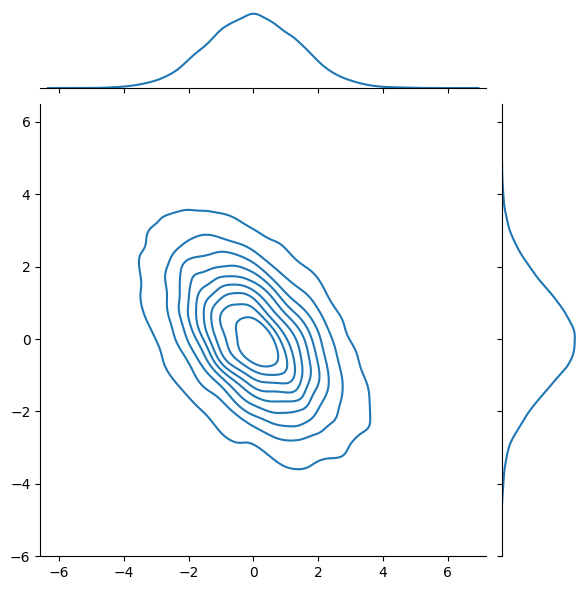

In [25]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

**Формула**

На основании статьи "[Расстояние Фреше между многомерными нормальными распределениями](https://core.ac.uk/reader/82269844)" Даусона и Ландау (1982) расстояние Фреше между двумя многомерными нормальными распределениями $X$ и $Y$ имеет вид:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$.

Аналогично формуле для одномерного расстояния Фреше, можно вычислить расстояние между средними и расстояние между стандартными отклонениями. Однако вычисление расстояния между стандартными отклонениями здесь несколько меняется, поскольку включает в себя матричное произведение и матричный квадратный корень. $\mathrm{Tr}$ - это след, сумма диагональных элементов матрицы.


In [6]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [7]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features)
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    return torch.norm(torch.sub(mu_x,mu_y)) + torch.trace(sigma_x + sigma_y - 2* matrix_sqrt(torch.matmul(sigma_x,sigma_y)))

In [29]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

Затем определим функцию для вычисления ковариации признаков, которая возвращает ковариационную матрицу, заданную списком значений:

In [30]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Наконец, можно использовать предварительно обученную модель Inception-v3 для вычисления признаков реального и поддельного изображений. По этим признакам можно получить ковариацию и среднее значение этих признаков по многим выборкам.

Сначала с помощью модели Inception-v3 были получены признаки реального и поддельного изображений:

In [36]:
device = "cpu"

In [37]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to('cpu')).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]

Затем можно объединить все значения, собранные для реальных и фальшивых величин, в большие тензоры:

In [8]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

NameError: name 'torch' is not defined

И вычислить ковариацию и среднее значение этих реальных и фальшивых признаков:

In [39]:
mu_fake = torch.mean(fake_features_all,dim=0)
mu_real = torch.mean(real_features_all, dim = 0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

На этом этапе можно также визуализировать, как выглядят парные многомерные распределения начальных признаков!

In [9]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

NameError: name 'mu_fake' is not defined

Наконец, можно использовать ранее полученную функцию `frechet_distance` для вычисления FID и оценки GAN. Вы можете увидеть, насколько похожи/отличаются признаки сгенерированных изображений от признаков реальных изображений.

In [41]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

82.91352844238281


# Perceptual Path Length (PPL)

Perceptual path length (PPL) - это метрика, которая была введена в [StyleGAN](https://arxiv.org/abs/1812.04948) для оценки того, насколько хорошо генератор справляется с плавной интерполяцией между точками в латентном пространстве. По сути, если перемещаться между двумя изображениями точек, полученными генератором, по прямой линии в латентном пространстве, то при суммировании неровностей каждого шага измеряется общая "неровность" интерполяции. В этом блокноте мы рассмотрим мотивацию и механизм, лежащий в основе PPL.

В работе [StyleGAN2](https://arxiv.org/abs/1912.04958) было отмечено, что метрика также "коррелирует с согласованностью и стабильностью форм", что привело к одному из основных изменений между двумя работами.


## Перцептивное сходство

Как и FID, PPL использует эмбеддинги признаков глубокой конволюционной нейронной сети. В частности, расстояние между двумя эмбеддинги изображений, предложенное в работе [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
] (https://arxiv.org/abs/1801.03924) Чжаном и др. (CVPR 2018). В данном подходе, в отличие от FID, вместо InceptionNet используется сеть VGG16. 

Перцептивное сходство близко к расстоянию между двумя векторами признаков с одним ключевым отличием: признаки пропускаются через обучаемое преобразование, которое натренировано на соответствие человеческой интуиции в отношении сходства изображений. В частности, если показать два изображения с различными преобразованиями базового изображения, то метрика LPIPS ("Learned Perceptual Image Patch Similarity") должна иметь меньшее расстояние для того изображения, которое, по мнению человека, ближе. 

![рисунок из статьи о перцептивном сходстве](Добавить рисунок)
* Рисунок из статьи [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric
](https://arxiv.org/abs/1801.03924), где показано исходное изображение в центре и два его преобразования. Человек, как правило, находит правое изображение более похожим на центральное, чем левое, и метрика LPIPS соответствует этому.*


Для нашей реализации мы можем использовать `lpips`. [library](https://github.com/richzhang/PerceptualSimilarity),  реализованный авторами статьи о перцептивном сходстве.


In [36]:
import lpips
# Outside of coursera, you don't need the following five lines:
from shutil import copyfile
import os

loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/mteterin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mteterin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/mteterin/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [00:17<00:00, 32.4MB/s]


Loading model from: /home/mteterin/.local/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [37]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [38]:
z_dim = 64
gen = Generator(z_dim)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location='cpu')["gen"])
gen = gen.eval()

## От LPIPS к PPL
Обратите внимание, что перцептивная длина пути строится непосредственно на метрике LPIPS.

StyleGAN не оперирует непосредственно со случайно отобранным латентным вектором. Вместо этого он обучается отображению $f$ из $z$ в $w$ - то есть $f(z) = w$. Cуществует два пространства, в которых можно вычислить PPL. 

### Линейная интерполяция (пространство $w$)

Для пространства $w$ PPL определяется следующим образом с помощью линейной интерполяции:

Сначала из двух произвольно выбранных точек в пространстве $w$, $w_1 = f(z_1)$ и $w_2 = f(z_2)$, берутся две точки в пространстве $z$. Для простоты будем считать, что $f$ - это функция тождества.

In [39]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.randn(1, z_dim)), map_fn(torch.randn(1, z_dim))

С помощью генератора вы получите два изображения, интерполирующих между $w_1$ и $w_2$, где сумма $w_1$ равна $t$, и одно, где сумма $w_1$ равна $t+\epsilon$. Можно считать, что $t$ - это выборка случайной точки на пути, интерполирующем между $w_1$ и $w_2$.

Для линейной интерполяции можно использовать функцию `torch.lerp`, а для равномерной выборки случайной точки $t$ от 0 до 1 - функцию `torch.rand`. Также здесь можно задать $\epsilon = 2 \cdot 10^{-1}$ для визуализации, хотя в статье StyleGAN $\epsilon = 10^{-4}$.


In [41]:
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)
y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

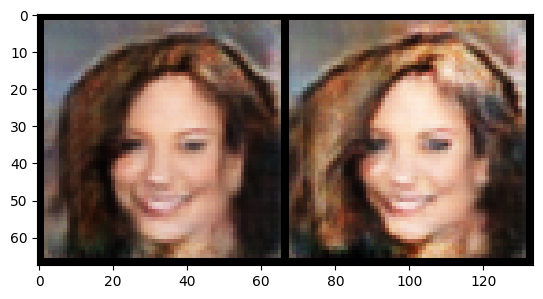

Image LPIPS is 0.16880643367767334


In [42]:
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item()
print(f"Image LPIPS is {cur_lpips}")

Наконец, необходимо учесть влияние различных значений $\epsilon$, чтобы длина перцептивного пути сходилась как $\epsilon\rightarrow \infty$. Для этого PPL делит на $\epsilon^2$. 

In [43]:
ppl = cur_lpips / (eps ** 2)
print(f"Our final sample PPL is {ppl}")

Our final sample PPL is 4.220160841941833


Таким образом, получается следующее общее уравнение: 

$$PPL_{w} = \mathbb{E}\left[\frac{1}{\epsilon^2} \mathop{d_{\mathrm{LPIPS}}}\left(\mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t\right), \mathop{\mathrm{G}}\left(\mathrm{lerp}(w_1, w_2, t + \epsilon\right)\right)\right]$$

Вы заметите символ ожидания: это потому, что все это многократно повторяется для аппроксимации PPL.

In [45]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    """
    Perceptual path length function: Combines the above steps into one PPL function
    """
    # Sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_w: {ppl_w(gen, nn.Identity()).item()}")

PPL_w: 20.161487579345703


### Сферическая интерполяция (пространство $z$)

Поскольку выборка точек в $z$ производится из гаусса, то для интерполяции в $z$-пространстве вместо линейной интерполяции используется сферическая интерполяция. Для этого мы можем использовать `scipy.spatial.geometric_slerp`.

$$slerp(z_1, z_2, t) = \frac{\sin[(1 - t) \cdot \Omega]}{\sin\Omega} z_1 + \frac{\sin[t \cdot \Omega]}{\sin\Omega} z_2$$.

где $ \Omega = \cos^{-1}(\mathrm{dot}(\bar{z}_1, \bar{z}_2))$, а $\bar{x}$ обозначает нормированную версию x.

In [46]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1 - t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

def ppl_z(gen, num_samples=10, eps=1e-4):
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_z: {ppl_z(gen).item()}")

PPL_z: 19.15634536743164
